# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import math
import time
import skimage.transform
%matplotlib inline

In [2]:
# Load pickled data
import pickle
def import_data():
    global X_train,y_train,X_test,y_test

    # TODO: Fill this in based on where you saved the training and testing data
    data_folder = "../traffic-signs-data"
    training_file = "/".join([data_folder,"train.p"])
    testing_file = "/".join([data_folder,"test.p"])

    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    X_train, y_train = train['features'], train['labels']
    X_test, y_test = test['features'], test['labels']
    
import_data()

In [3]:
# load signames
sign_names = pd.read_csv("signnames.csv")
sign_names

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [4]:
def plot_image(img):
    cmap = 'gray' if np.ndim(img) == 2 else None
    plt.axis('off')
    plt.imshow(img, cmap='gray', interpolation='none')


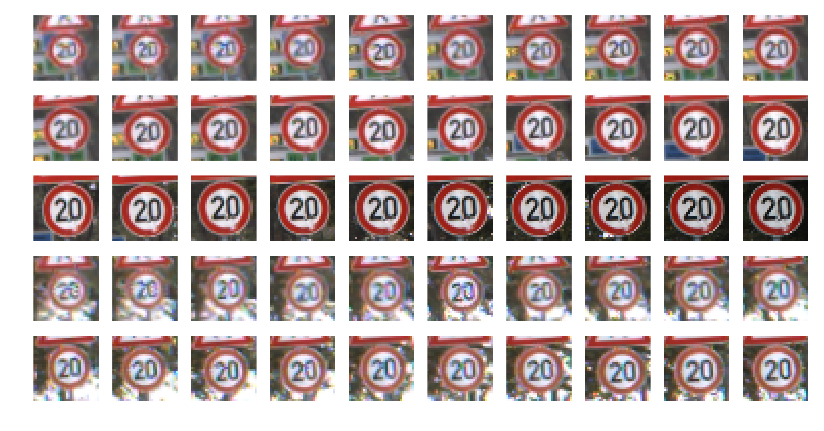

In [5]:
def plot_images(l, images_per_line = 10, image_size_inches = 1.0, title=None):
    fig=plt.figure()
    if title is not None:
        fig.suptitle(title)
    line_count=math.ceil(len(l)/images_per_line)
    fig.set_size_inches(w=images_per_line*image_size_inches,h=line_count*image_size_inches)
    for i in range(len(l)):
        img=l[i]
        plt.subplot(line_count,10,i+1)
        plot_image(img)


plot_images(X_train[0:50],image_size_inches=1)

In [6]:
#returns indexes of items in l with value x
def find(l,x):
    return [i for i, v in enumerate(l) if v==x]

In [7]:
def show_images_by_category():
    plt.rcParams.update({'figure.max_open_warning': 0}) # get rid of warning for too many figures

    for r in sign_names.itertuples():
        matching_indexes=find(y_train,r.ClassId)
        matching_images = []
        for i in matching_indexes[0:5]:
            matching_images.append(X_train[i])
        plot_images(matching_images,title=r.SignName)
    
# show_images_by_category()

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [8]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
#n_train = len(X_train)

# TODO: Number of testing examples.
#n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = np.shape(X_train[0])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", len(X_train))
print("Number of testing examples =", len(X_test))
print("Image data shape =", np.shape(X_train[0]))
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [9]:
import random
def random_from_lists(list1,list2,n=None):
    if n is None:
        n = len(list1)
    indexes = random.sample(range(len(list1)),n)
    out1 = []
    out2 = []
    for i  in indexes:
        out1.append(list1[i])
        out2.append(list2[i])
    return np.array(out1),np.array(out2)

x=[1,2,3]
y=[4,5,6]
random_from_lists(x,y)
_x,_y=random_from_lists(X_train,y_train,3)
np.shape(_x),np.shape(X_train)

((3, 32, 32, 3), (39209, 32, 32, 3))

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [10]:
# returns n random samples out of x
def random_sample(x,n):
    if n > len(x): n = x
    indexes =np.random.choice(range(len(x)),n)
    r = []
    for i in indexes:
        r.append(x[i])
    return np.array(r)

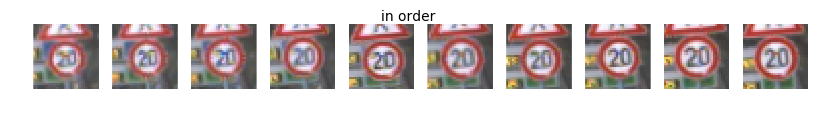

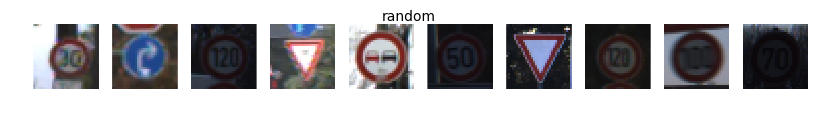

In [11]:
plot_images(X_train[0:10],title="in order")
plot_images(random_sample(X_train,10),title="random")

In [12]:
def preprocess_image(img, dst=None, use_yuv=False):
    if dst is None:
        dst = np.zeros_like(img)
    if use_yuv:
        yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        y,u,v=cv2.split(yuv)
        #cv2.equalizeHist(y,y)
        y=(y-y.min())*(255./(y.max()-y.min()))
        y=y.astype(np.uint8)
        yuv=cv2.merge((y,u,v))
        dst = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
    else:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h,s,v=cv2.split(hsv)
        v=(v-v.min())*(255./(v.max()-v.min()))
        v=v.astype(np.uint8)
        hsv=cv2.merge((h,s,v))
        dst = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return dst
    

In [13]:
def preprocess_image_bw(img):
    g =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        
    g=(g-g.min())*(255/(g.max()-g.min()))
    g=g.astype(np.uint8)
    return g
    

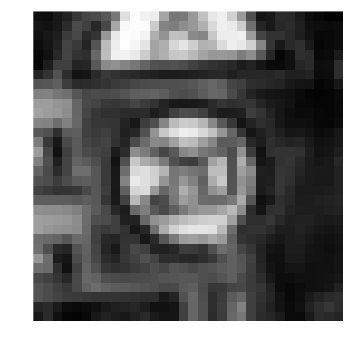

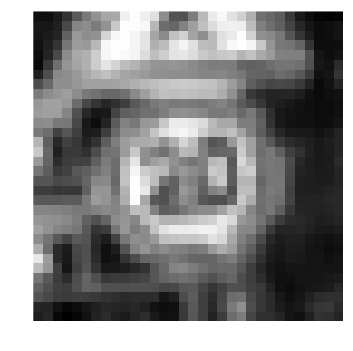

In [14]:
img = X_train[0]
gray = preprocess_image_bw(img)
plt.figure()
plot_image(gray)
plt.figure()
plot_image(img[:,:,0])

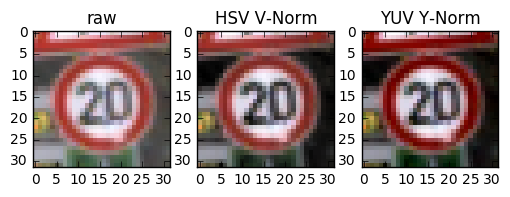

In [15]:
#demonstration of preprocessing an image
img = X_train[12]
plt.subplot(1,3,1)
plt.imshow(img,interpolation='none')
plt.title("raw")
plt.subplot(1,3,2)
plt.title("HSV V-Norm")
plt.imshow(preprocess_image(img),interpolation='none')
plt.subplot(1,3,3)
plt.title("YUV Y-Norm")
plt.imshow(preprocess_image(img, use_yuv=True),interpolation='none')
pass

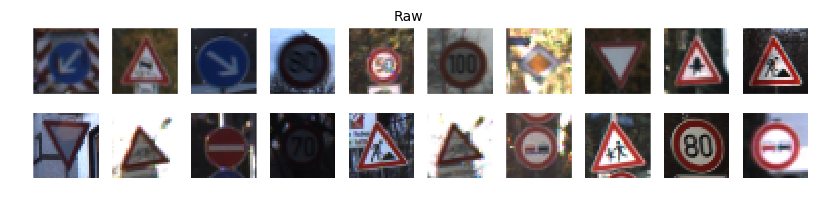

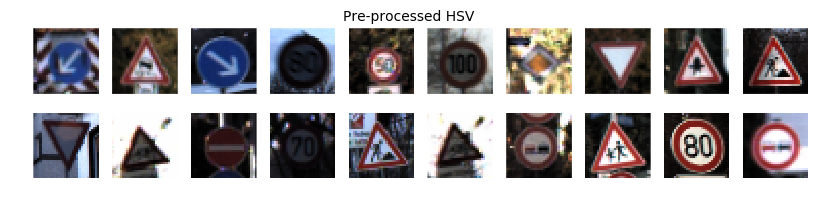

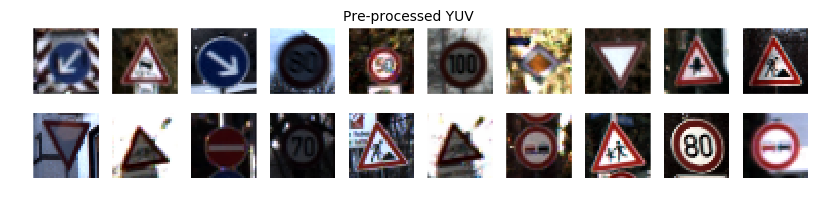

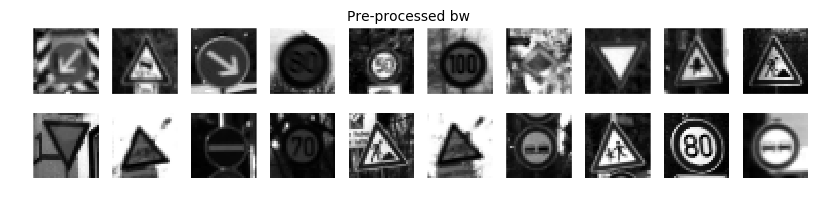

In [16]:
# visually show the different options of pre-processing
o = random_sample(X_train,20)
plot_images(o,title='Raw')
plot_images([preprocess_image(i) for i in o], title='Pre-processed HSV')
plot_images([preprocess_image(i,use_yuv=True) for i in o], title='Pre-processed YUV')
plot_images([preprocess_image_bw(i) for i in o], title='Pre-processed bw')

In [17]:
def yuv_images(images):
    return images
    #return np.array([cv2.cvtColor( preprocess_image(img), cv2.COLOR_BGR2YUV) for img in images])
    

X_train_yuv = yuv_images(X_train)
X_test_yuv = yuv_images(X_test)


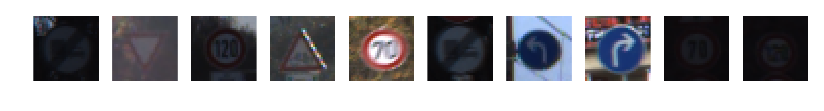

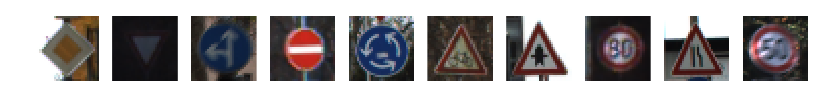

In [18]:
plot_images(random_sample(X_train_yuv,10))
plot_images(random_sample(X_test_yuv,10))


In [19]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.


In [20]:
X_train_bw = np.array([preprocess_image_bw(img) for img in X_train])
X_test_bw = np.array([preprocess_image_bw(img) for img in X_test])

In [21]:

len(X_train_bw)

39209

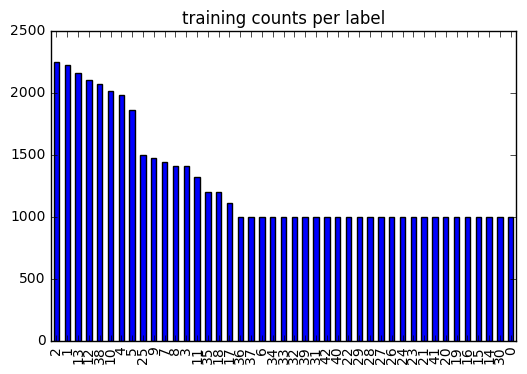

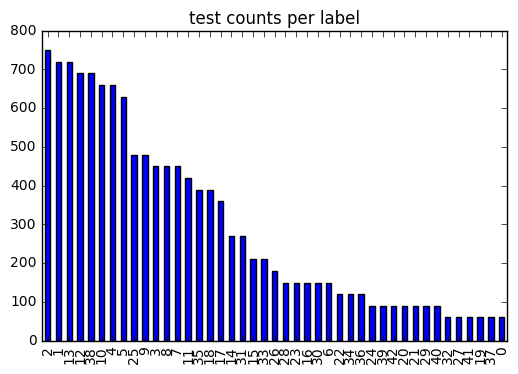

In [67]:

fig = plt.figure()
fig.set_size_inches(w=8,h=4)

plt.figure()
pd.value_counts(new_y).plot(kind="bar",title="training counts per label")
plt.figure()
pd.value_counts(y_test).plot(kind="bar",title="test counts per label")
pass
#plt.hist(y_train)

In [23]:
def euclidean_transform(m=None,cx=0.0,cy=0.0,theta=0.,scale=1.0,dx=0,dy=0):
    if m is None:
        m = np.eye(3)
    
    # center offset
    c = np.array([[1,0,cx],[0,1,cy], [0,0,1]]) 
    ci = np.array([[1,0,-cx],[0,1,-cy], [0,0,1]]) 
    
    # translation
    t = np.array([[1,0,dx],[0,1,dy], [0,0,1]])
    
    # rotation
    r = np.array([[math.cos(theta),-math.sin(theta),0],[math.sin(theta),math.cos(theta),0],[0,0,1]])
    
    # scale
    s = np.array([[scale,0,0],[0,scale,0],[0,0,1]])
    
    v = np.dot(m,c)
    v = np.dot(v,r)
    v = np.dot(v,s)
    v = np.dot(v,ci)
    v = np.dot(v,t)
    return v

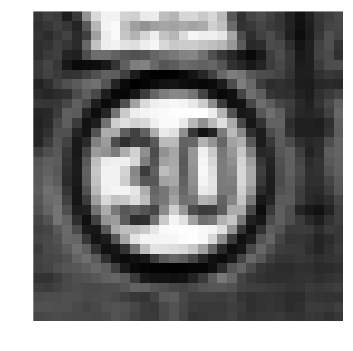

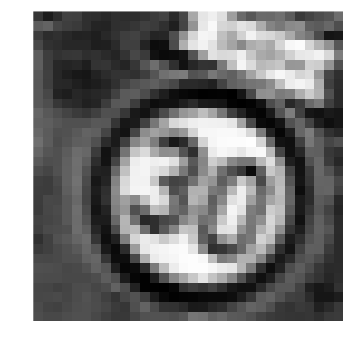

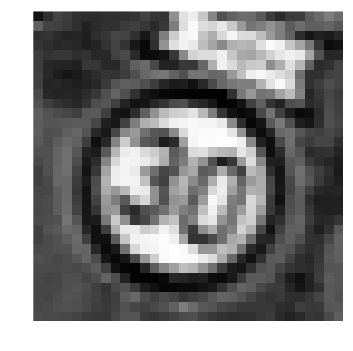

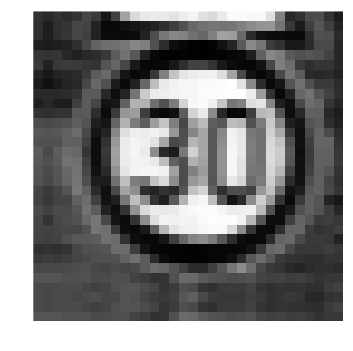

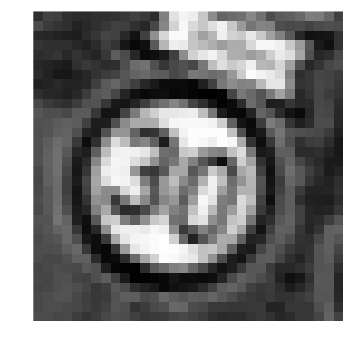

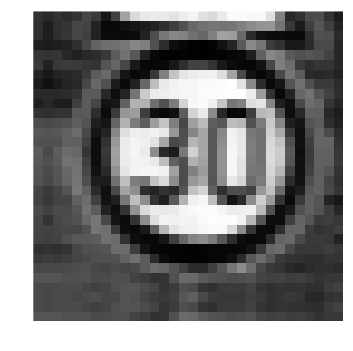

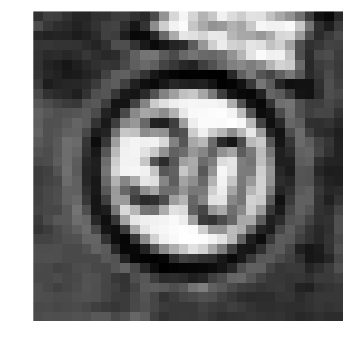

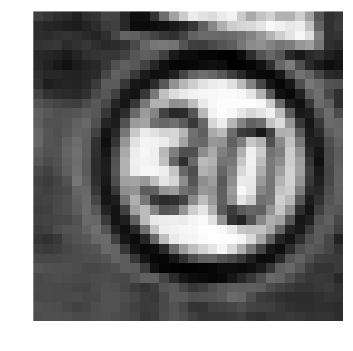

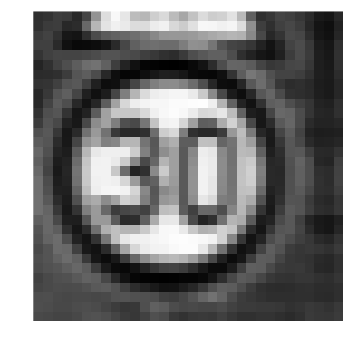

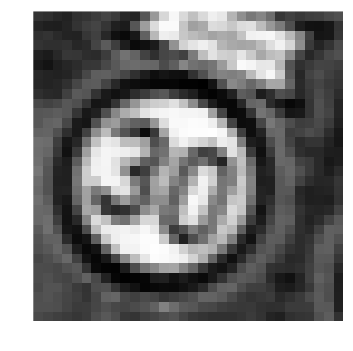

In [68]:
def transformed_image(img,theta=0.0,dx=0.0,dy=0.0,scale=1.0):
    cx,cy = np.shape(img)
    cx = cx / 2
    cy = cy / 2
    t = euclidean_transform(cx=cx,cy=cy,theta=theta,dy=dy,dx=dx,scale=scale)
    return skimage.transform.warp(img, inverse_map=np.linalg.inv(t),mode='reflect')


def augmented_image(img):
    theta = random.choice([-15,-10,-5,0,5,10,15,20])
    dx = random.choice([-2,-1,0,1,2])
    dy = random.choice([-2,-1,0,1,2])
    scale = random.choice([.95,1.0,1.05])
    return transformed_image(img,theta * math.pi/180,dx,dy,scale)

img = X_train_bw[1000]
for i in range(10):
    plt.figure()
    plot_image(augmented_image(img))

In [69]:
def augment_images():
    global y_train,X_train_bw
    new_x = np.copy(X_train_bw)
    new_y = np.copy(y_train)
    counts = np.bincount(y_train)
    labels = np.unique(y_train)
    minimum_count = 1000
    for i in range(len(labels)):
        label = labels[i]
        count = counts[i]
        print ("label: {} count: {}".format(label,count))
        if count < minimum_count:
            print("generating ",end="")
            number_to_generate = minimum_count - count
            image_indexes = find(y_train,label)
            new_images = []
            new_labels = []
            for _ in range(number_to_generate):
                original = X_train_bw[random.choice(image_indexes)]
                new_images.append(augmented_image(original))
                new_labels.append(label)
                print(" .",end="")
            print()
            print(np.shape(new_x))
            print(np.shape(np.array(new_images)))
            new_x = np.append(new_x,np.array(new_images),axis=0)
            new_y = np.append(new_y,np.array(new_labels,dtype=np.int64),axis=0)
    return new_x,new_y
            
          

In [70]:
np.array([1,2,3]).dtype

dtype('int64')

In [71]:
new_x,new_y = augment_images()

label: 0 count: 210
generating  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [72]:
np.shape(y_train),np.shape(new_y),np.shape(X_train_bw),np.shape(new_x)

((39209,), (54710,), (39209, 32, 32), (54710, 32, 32))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [73]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [74]:
from tensorflow.contrib.layers import flatten
def LeNet(x):
    # Reshape from 2D to 4D. This prepares the data for
    # convolutional and pooling layers.
    #x = tf.reshape(x, (-1, 28, 28, 1))
    x = tf.reshape(x, (-1, 32, 32, 1))
    # Pad 0s to 32x32. Centers the digit further.
    # Add 2 rows/columns on each side for height and width dimensions.
    #x = tf.pad(x, [[0, 0], [2, 2], [2, 2], [0, 0]], mode="CONSTANT")

    # Hyperparameters
    mu = 0.0
    sigma = 0.01

    # SOLUTION: Convolution Layer 1. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #conv1       = tf.nn.dropout(conv1,keep_prob=0.8)
    # SOLUTION: Activation 1.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling Layer 1. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Convolution Layer 2. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    #conv2       = tf.nn.dropout(conv2,keep_prob=0.8)

    # SOLUTION: Activation 2.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling Layer 2. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten Layer.
    fc1 = flatten(conv2)
    fc1_shape = (fc1.get_shape().as_list()[-1], 120)

    # SOLUTION: Fully Connected Layer 1. Input = 5x5x16. Output = 120.
    fc1_W     = tf.Variable(tf.truncated_normal(shape=(fc1_shape), mean = mu, stddev = sigma))
    fc1_b     = tf.Variable(tf.zeros(120))
    fc1       = tf.matmul(fc1, fc1_W) + fc1_b
    fc1       = tf.nn.dropout(fc1,keep_prob=1.0-dropout_rate)

    # SOLUTION: Activation 3.
    fc1 = tf.nn.relu(fc1)

    # SOLUTION: Fully Connected Layer 2. Input = 120. Output = n_classes.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, n_classes), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc1, fc2_W) + fc2_b

    return logits

In [75]:
x = tf.placeholder(tf.float32, (None, 32, 32))
y = tf.placeholder(tf.int32, (None))
dropout_rate = tf.placeholder(tf.float32,(None))
one_hot_y = tf.one_hot(y, n_classes)

fc2 = LeNet(x)

In [76]:
loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(fc2, y))
train_op = tf.train.AdamOptimizer().minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(one_hot_y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
predict_op = tf.argmax(fc2, 1)

In [77]:
def eval_data(x_data_in,y_data_in,batch_size=256):
    """
    Given a dataset as input returns the loss and accuracy.
    """
    # If dataset.num_examples is not divisible by BATCH_SIZE
    # the remainder will be discarded.
    # Ex: If BATCH_SIZE is 64 and training set has 55000 examples
    # steps_per_epoch = 55000 // 64 = 859
    # num_examples = 859 * 64 = 54976
    #
    # So in that case we go over 54976 examples instead of 55000.
    #steps_per_epoch = dataset.num_examples // BATCH_SIZE
    steps_per_epoch=np.size(y_data_in)//batch_size
    num_examples = steps_per_epoch * batch_size
    total_acc, total_loss = 0, 0
    sess = tf.get_default_session()
    for step in range(steps_per_epoch):
        n_start = step*batch_size        
        batch_x =  x_data_in[n_start:n_start+batch_size]
        batch_y =  y_data_in[n_start:n_start+batch_size]
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, dropout_rate:0.0})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
    return total_loss/num_examples, total_acc/num_examples

In [78]:
class Object:
    pass

In [79]:
def train_network(x_data, y_data, x_testp, y_testp, sess, epochs=20, batch_size=32):
    sess.run(tf.global_variables_initializer())
    steps_per_epoch = len(y_data) // batch_size
    num_examples = steps_per_epoch * batch_size

    losses = []
    accuracies = []
    train_losses = []
    train_accuracies = []
    # Train model
    for i in range(epochs):
        train_loss = 0.0
        train_accuracy = 0.0
        for step in range(steps_per_epoch):
            n_start = step*batch_size
            #print(n_start)
            batch_x = x_data[n_start:n_start+batch_size,:,:]
            batch_y = y_data[n_start:n_start+batch_size]
            _,loss,accuracy = sess.run([train_op,loss_op,accuracy_op], feed_dict={x: batch_x, y: batch_y, 
                                                                                  dropout_rate:0.5})
            train_loss += loss
            train_accuracy += accuracy
        train_loss /= steps_per_epoch
        train_accuracy /= steps_per_epoch
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_acc = eval_data(x_testp, y_testp, batch_size=512)
        losses.append(val_loss)
        accuracies.append(val_acc)
        print("EPOCH {} .".format(i+1), end="")
        print(" Training loss = {:.3f}".format(train_loss), end="")
        print(" Training accuracy = {:.3f}".format(accuracy), end="")
        print(" Validation loss = {:.3f}".format(val_loss), end="")
        print(" Validation accuracy = {:.3f}".format(val_acc))
        
    run = Object()
    run.test_losses = losses
    run.test_accuracies = accuracies
    run.train_losses = train_losses
    run.train_accuracies = train_accuracies
    return run

In [82]:
try:
    session.close()
except:
    pass
session = tf.InteractiveSession()
#_x,_y=random_from_lists(X_train_bw,y_train)
_x,_y=random_from_lists(new_x,new_y)
run = train_network(_x,_y,X_test_bw,y_test, sess=session, epochs=150, batch_size=512)

EPOCH 1 ... Training loss = 3.020 Training accuracy = 0.402 Validation loss = 1.240 Validation accuracy = 0.658
EPOCH 2 ... Training loss = 1.767 Training accuracy = 0.586 Validation loss = 0.705 Validation accuracy = 0.820
EPOCH 3 ... Training loss = 1.480 Training accuracy = 0.609 Validation loss = 0.587 Validation accuracy = 0.856
EPOCH 4 ... Training loss = 1.321 Training accuracy = 0.654 Validation loss = 0.500 Validation accuracy = 0.882
EPOCH 5 ... Training loss = 1.193 Training accuracy = 0.676 Validation loss = 0.510 Validation accuracy = 0.879
EPOCH 6 ... Training loss = 1.050 Training accuracy = 0.711 Validation loss = 0.450 Validation accuracy = 0.899
EPOCH 7 ... Training loss = 0.954 Training accuracy = 0.682 Validation loss = 0.473 Validation accuracy = 0.902
EPOCH 8 ... Training loss = 0.894 Training accuracy = 0.738 Validation loss = 0.439 Validation accuracy = 0.912
EPOCH 9 ... Training loss = 0.850 Training accuracy = 0.740 Validation loss = 0.436 Validation accuracy 

Max accuracy 0.946695963542


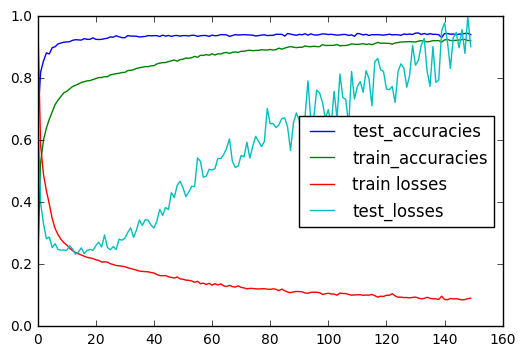

In [83]:
plt.plot(run.test_accuracies,label='test_accuracies')
plt.plot(run.train_accuracies,label='train_accuracies')
plt.plot(run.train_losses/np.max(run.train_losses),label='train losses')
plt.plot(run.test_losses/np.max(run.test_losses),label='test_losses')
plt.legend(loc='best')
print("Max accuracy",max(run.test_accuracies))


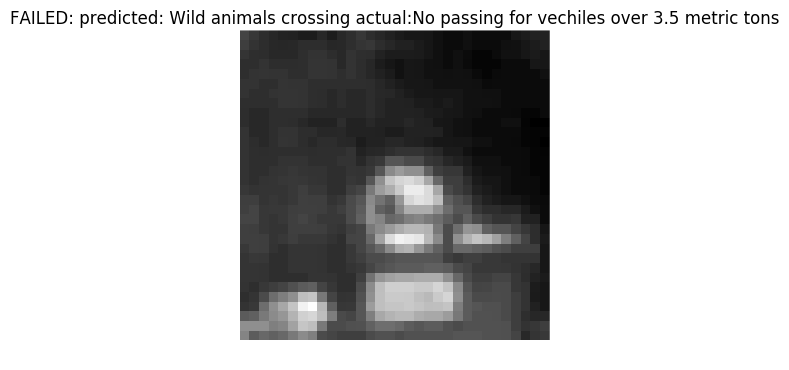

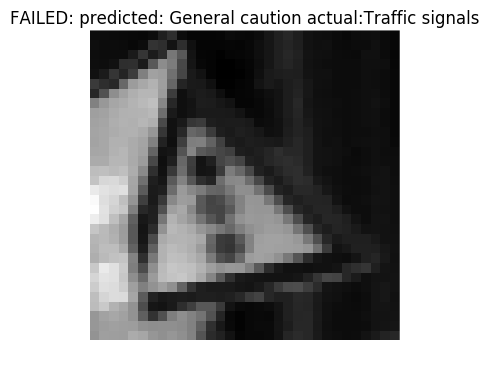

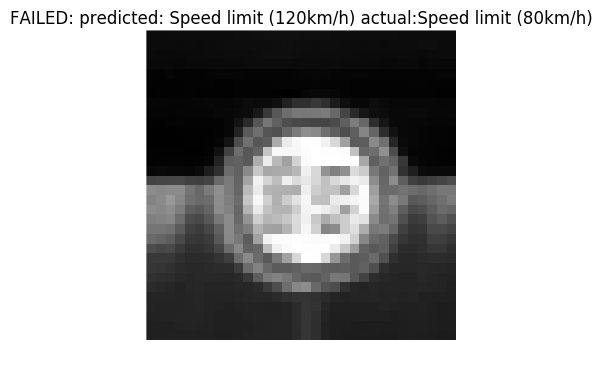

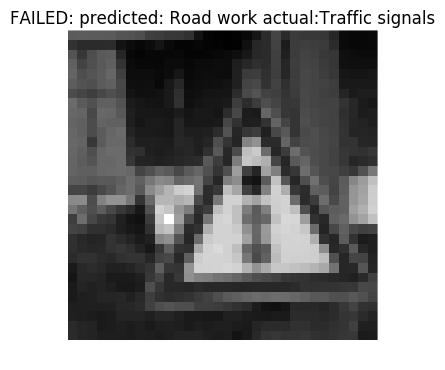

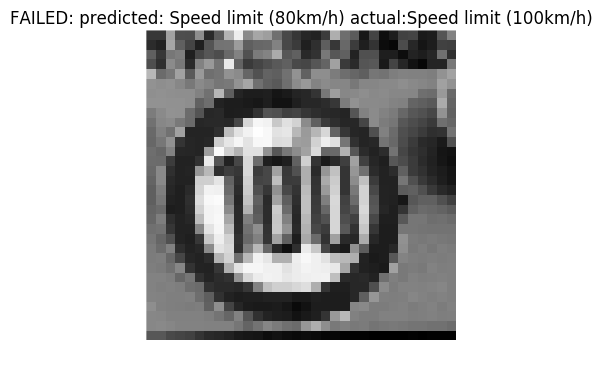

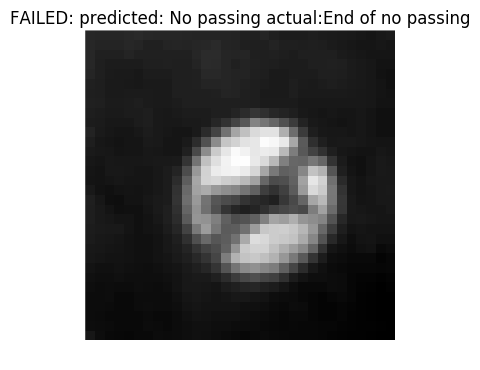

In [84]:
sample_x,sample_y = random_from_lists(X_test_bw,y_test,100)

for i in range(len(sample_x)):
    predicted = predict_op.eval(feed_dict={x: sample_x[i:i+1,:,:], dropout_rate:0.0})[0]
    actual=sample_y[i]
    if(predicted==actual):
        pass
        #plt.title("ok: {}".format(sign_names.SignName[predicted]))
    else:
        plt.figure()
        plot_image(sample_x[i])
        plt.title("FAILED: predicted: {} actual:{}".format(sign_names.SignName[predicted],sign_names.SignName[actual]))
    
    

In [ ]:
x_input = X_train_bw[0:2,:,:]
output = [0,0]
sess = tf.Session()
labels = session.run([predict_op], feed_dict={x: x_input, dropout_rate:0.0})
print (labels)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I tried different batch sizes.  Larger batch sizes were faster, but smaller batches, on the order of 32 seemed to work better.

I manually looked the images before trying any training.  I did normalization of the image to make it look better to my eye.

I was getting about 77% accuracy with the LeNet starter code.  I added a dropout term, and noticed that while training took olonger, accuracy jumped to about 88%  That was a huge improvement.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.